In [1]:
import pandas as pd
import pickle
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from model.inference_utils import match_align
from visualization.visualization import plot_metric_trajectory

/Users/abhijitbrahme/.pyenv/versions/3.11.9/envs/nba_functional_analysis_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functional Analysis of NBA Player Career Trajectory 
We are working in a multi-output setting, one where we wish to produce multiple trajectories of player careers across different metrics.
Metrics are either:
1. Gaussian with observed / unobserved response and corresponding observed /unobserved variance terms. (OBPM, DBPM)
2. Poisson with observed / unobserved response and corresponding observed / unobserved exposure terms. (OREB Rate, BLK Rate, STL Rate, AST Rate, FTA Rate, FG2A Rate, FG3A Rate)
3. Binomial with observed / unobserved response and corresponding observed / unobserved exposure terms. (FT %, 2FG%, 3FG%)

Let the index $J$ denote the metric, $N$ denote the player, and $T$ denote the years 18-39 of player career. Thus, our data is a tensor of size $N x T x J$ with missing entries if player $n$ did not record statistics at time $t$ for metric $j$. This could be due to retirement, injury, etc. 

We seek to model these observations in the following way:

$$ \mu_j = X^T \Phi_j(T) + \alpha_j $$ 

Here, $X$ is a fixed predictor of size $N$ X  $d$ where d << N. $\Phi_j(T)$ corresponds to a functional coefficient for metric $j$, and $\alpha_j$ corresponds to an intercept term. 

Note that since we have different response distributions, we must include the following conditions:
1. If $j$ is a Gaussian distributed response,
$$ y_j \sim N(\mu_j, \frac{\sigma^2_j}{p_j}) $$
2. If $j$ is a Poisson distributed response, 
$$  y_j \sim Pois(p_j exp(\mu_j)) $$
3. If $j$ is a Binomial distributed response,
$$ y_j \sim Bin(p_j, logit(\mu_j)) $$

Here, $p_j$ is the exposure term for the appropriate metric. If $y_j$ is Binomial, $p_j$ represents the number of trials, and so on. Practically, $p_j$ is the number of shot attempts for binomial distributed response, and number of minutes played for other responses. 


It is also important to note that $\Phi_j(T)$ is created by using a HSGP approximation, with 10 truncation limit. These are independent across metrics $j$. 

In [2]:
data = pd.read_csv("data/player_data.csv").query(" age <= 38 ")
# data = data.groupby("id").filter(lambda x: x.games.sum() >= 50)

In [3]:
data.head()

,year,season,id,minutes,fg2m,fg2a,fg3a,fg3m,ftm,fta,...,position,team,age,obpm,dbpm,bpm,games,total_seasons,median_minutes_per_game,max_minutes
0,1997,1996-97,2,1439.778333,90,191,188,73,127,151,...,SG,LAL,35,0.6,0.4,1.0,79,1,18.225042,1439.778333
1,1997,1996-97,3,1170.195000,106,228,47,17,63,84,...,PF,DET,30,-1.0,0.3,-0.6,65,7,21.958214,1868.101667
2,1998,1997-98,3,741.726667,50,113,4,0,41,57,...,PF,DET,31,-2.6,1.5,-1.1,40,7,21.958214,1868.101667
3,1999,1998-99,3,1380.178333,148,341,18,3,184,235,...,PF,ATL,32,-0.3,1.7,1.5,50,7,21.958214,1868.101667
4,2000,1999-00,3,922.245000,74,163,4,0,55,71,...,PF,VAN,33,-1.9,0.3,-1.7,42,7,21.958214,1868.101667


In [4]:
names = data.groupby("id")["name"].first().values

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
agg_dict = {"obpm":"mean", "dbpm":"mean", "bpm":"mean", 
            "minutes":"sum", "dreb": "sum", "fta":"sum", "ftm":"sum", "oreb":"sum",
            "ast":"sum", "tov":"sum", "fg2m":"sum", "fg3m":"sum", "fg3a":"sum", "fg2a":"sum", "blk":"sum", "stl":"sum"}
data["total_minutes"] = data["median_minutes_per_game"] * data["games"] 
agged_data = data.groupby("id").agg(agg_dict).reset_index()
agged_data["ft_pct"] = agged_data["ftm"] / agged_data["fta"]
agged_data["fg2_pct"] = agged_data["fg2m"] / agged_data["fg2a"]
agged_data["fg3_pct"] = agged_data["fg3m"] / agged_data["fg3a"]
agged_data["dreb_rate"] = agged_data["dreb"] / agged_data["minutes"]
agged_data["oreb_rate"] = agged_data["oreb"] / agged_data["minutes"]
agged_data["ast_rate"] = agged_data["ast"] / agged_data["minutes"]
agged_data["tov_rate"] = agged_data["tov"] / agged_data["minutes"]
agged_data["blk_rate"] = agged_data["blk"] / agged_data["minutes"]
agged_data["stl_rate"] = agged_data["stl"] / agged_data["minutes"]
agged_data.fillna(0, inplace=True)

latent_metrics = ["obpm","dbpm","minutes","ft_pct","fg2_pct","fg3_pct","dreb_rate","oreb_rate","ast_rate","tov_rate","blk_rate","stl_rate"]
X = StandardScaler().fit_transform(agged_data[latent_metrics])
pca_x = PCA().fit(X)
X_pca = pca_x.transform(X)


In [ ]:

plt.bar(latent_metrics, height=pca_x.components_[0,:])
plt.xticks(rotation = 90)
plt.ylabel("PCA Loading for PC 1")

In [ ]:

plt.bar(latent_metrics, height=pca_x.components_[0,:])
plt.xticks(rotation = 90)
plt.ylabel("PCA Loading for PC 1")

In [ ]:

plt.bar(latent_metrics, height=pca_x.components_[1,:])
plt.xticks(rotation = 90)
plt.ylabel("PCA Loading for PC 2")

In [ ]:
plt.bar(latent_metrics, height=pca_x.components_[2,:])
plt.xticks(rotation = 90)
plt.ylabel("PCA Loading for PC 3")

In [ ]:
star_indices = np.where(data.groupby("id")["name"].first().reset_index()["name"].isin(["Stephen Curry", "Nikola Jokic", "Kevin Durant", "Kobe Bryant", "Luka Doncic", "Michael Jordan"]))[0]

In [ ]:
# Step 2: Calculate distances
centroid = np.mean(X_pca[:,0:3], axis=0)
distances = np.linalg.norm(X_pca[:, 0:3] - centroid, axis=1)

# Step 3: Define Threshold
# Example: Threshold as 2 standard deviations from the mean distance
threshold = np.mean(distances) + 2.5 * np.std(distances)

# Step 4: Label Outliers
outliers_indices = np.where(distances > threshold)[0]

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1])
# Annotate outliers
for i in outliers_indices:
    plt.annotate(names[i], (X_pca[i, 0], X_pca[i, 1]), fontsize=7)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

In [ ]:
plt.scatter(X_pca[:,1], X_pca[:,2])
# Annotate outliers
for i in outliers_indices:
    plt.annotate(names[i], (X_pca[i, 1], X_pca[i, 2]), fontsize=7)
plt.xlabel("PC 2")
plt.ylabel("PC 3")

### Looking at Results
The above model was fit in numpyro with 1000 warmup iterations and 4 chains. 

In [ ]:
with open("model_output/nba_fda_model.pkl", "rb") as f:
    results = pickle.load(f)
f.close()

In [ ]:
inference_data = az.from_dict(results)

In [ ]:
az.summary(inference_data)

In [ ]:
az.plot_trace(inference_data, var_names="length")

### Functional Analysis of NBA Player Career Trajectory (Latent Variable Model)
We do the same as we did in the previous section, except $X$ is not fixed. We constrain $X$ to be orthonormal by sampling $X$ from the Stiefel Manifold. 

### Looking at Latent Model Results

In [ ]:
with open("model_output/nba_fda_latent_model.pkl", "rb") as f:
    latent_results = pickle.load(f)
f.close()

In [ ]:
latent_raw = latent_results["latent_raw"]

In [ ]:
latent_raw_square = np.einsum("cdjk,cdjb -> cdkb", latent_raw, latent_raw)

In [ ]:
U, L, V = np.linalg.svd(latent_raw_square)

In [ ]:
latent = np.matmul(latent_raw, np.matmul(U * np.power(L[...,None], -.5), V))

In [ ]:
latent_results["latent"] = latent

In [ ]:
inference_data_latent = az.from_dict(latent_results)

In [ ]:
az.summary(inference_data_latent)

One thing to note is the poor diagnostic results here, indicating that the chains have not mixed properly. One thing to do would be to look at the trace-plots of some of these variables. In particular, we can look at the first element of the basis variable. The reason for this may be due to factor identifiability issues, since rotations of $X$ and the basis functions can yield equivalent posteriors. 

In [ ]:
az.plot_trace(inference_data_latent, var_names="basis", coords={"basis_dim_0":0, "basis_dim_1":0, "basis_dim_2":0})

As we can see, we see clearly that the chains have not mixed at all. The posterior is quite multi-modal in this regard. One thing that would be interesting to check would be to also look at the variable $X$. We need to transform the variable, to run the appropriate statistics. 

In [ ]:
az.plot_trace(inference_data_latent, var_names="latent", coords={"latent_dim_0":0, "latent_dim_1":0})

Again, we kind of see that there is multi-modality in the posterior of the latent space, essentially 2 chains that may or may not be equivalent in terms of the posterior likelihood.

In [ ]:
az.plot_trace(inference_data_latent, var_names="latent", coords={"latent_dim_0":0, "latent_dim_1":2})

In [ ]:
az.plot_trace(inference_data_latent, var_names="latent_raw", coords={"latent_raw_dim_0":0, "latent_raw_dim_1":2})

### Visualizing Latent Space

Here, we can visualize the latent space of one chain and see if there is any interesting separation. Previously in the PCA, we didn't see any interesting information. Although the chains may not have mixed, we can still examine the latent space from one chain to see if there are any interesting behaviors. 

In [ ]:
latent_draw = latent[-4,-1, :, :]

In [ ]:
plt.scatter(latent_draw[:,0], latent_draw[:,1])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (latent_draw[i, 0], latent_draw[i, 1]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

In [ ]:
plt.scatter(latent_draw[:,1], latent_draw[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (latent_draw[i, 1], latent_draw[i, 2]), fontsize=7)
plt.xlabel("Latent 2")
plt.ylabel("Latent 3")

## Results for PPCA 

This model seeks to factorize the long $N$ by $TK$ matrix using probabilistic Principal Component Analysis. Since we have various outputs that are not normally distributed, this becomes a form of exponential PCA. 

In [ ]:
with open("model_output/exponential_pca.pkl", "rb") as f:
    results = pickle.load(f)
f.close()

In [ ]:
X_ppca = results["W_auto_loc"]

Z_ppca = linkage(X_ppca, optimal_ordering=True, method="centroid")

dendrogram(Z_ppca, labels=names, p = 100, truncate_mode="lastp", show_leaf_counts=False)

In [ ]:
plt.scatter(X_ppca[:,0], X_ppca[:,1])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_ppca[i, 0], X_ppca[i, 1]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

In [ ]:
plt.scatter(X_ppca[:,1], X_ppca[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_ppca[i, 1], X_ppca[i, 2]), fontsize=7)
plt.xlabel("Latent 2")
plt.ylabel("Latent 3")

In [ ]:
plt.scatter(X_ppca[:,0], X_ppca[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_ppca[i, 0], X_ppca[i, 2]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 3")

### Functional Bases

In [ ]:
bases_ppca = results["beta_auto_loc"].reshape(3, int(252 // 12), -1)
alpha = results["alpha_auto_loc"].reshape(int(252/12), -1)

In [ ]:
metrics = ["log_min", "obpm","dbpm","blk","stl","ast","dreb","oreb","tov","fta","fg2a","fg3a","ftm","fg2m","fg3m"]
basis = np.arange(18,39)

In [ ]:
for index, metric in enumerate(metrics):
    _df = pd.DataFrame(bases_ppca[:,:, index].T , columns=[f"basis {i}" for i in range(3)])
    _df["age"] = basis
    _df.plot(x="age", y=[f"basis {i}" for i in range(3)], xlabel="age",
         ylabel="Value", title=f"Metric: {metric}")


## Results for Probabilistic CP Decomposition 

This model seeks to factorize the  $N$ by $T$ by $K$ tensor (A) using probabilistic exponential family CP Decomposition. Since we have various outputs that are not normally distributed, this becomes a form of exponential family CP Decomposition.

We seek to approximate the following:

$A \approx \mu + \sum_{i=1}^{r} \lambda_i \cdot u_i \otimes v_i \otimes w_i$

where, $\mu$, $u_i$, $v_i$, $w_i$ $\sim \mathcal{N}(0, I)$, $\lambda \sim Dirichlet(\alpha)$

$U \in \mathcal{R}^{N x R}$

$V \in \mathcal{R}^{T x R}$

$w \in \mathcal{R}^{K x R}$

$\mu \in \mathcal{R}^{T x K}$. 

Here $\mu$ is used to de-mean the data, and $r = 2$. 


In [ ]:
with open("model_output/exponential_cp.pkl", "rb") as f:
    results = pickle.load(f)
f.close()

In [ ]:
X_pcp = results["U_auto_loc"]


Z_pcp = linkage(X_pcp, optimal_ordering=True, method="centroid")

dendrogram(Z_pcp, labels=names, p = 100, truncate_mode="lastp", show_leaf_counts=False)

In [ ]:
plt.scatter(X_pcp[:,0], X_pcp[:,1])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_pcp[i, 0], X_pcp[i, 1]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

In [ ]:
plt.scatter(X_pcp[:,1], X_pcp[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_pcp[i, 1], X_pcp[i, 2]), fontsize=7)
plt.xlabel("Latent 2")
plt.ylabel("Latent 3")

In [ ]:
plt.scatter(X_pcp[:,0], X_pcp[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_pcp[i, 0], X_pcp[i, 2]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 3")

### Functional Bases

In [ ]:
V_pcp = results["V_auto_loc"]
W_pcp = results["W_auto_loc"]
alpha = results["alpha_auto_loc"]
lam = results["lambda_auto_loc"]

In [ ]:
lam

In [ ]:
bases_pcp = np.einsum("tr,kr -> tkr", V_pcp,W_pcp)
bases_sum_pcp = np.einsum("tkr,r -> tk", bases_pcp, lam) + alpha

## Plotting individual Tensor Production Curves

In [ ]:
for index, metric in enumerate(metrics):
    _df = pd.DataFrame(bases_pcp[:,index, :] , columns=[f"basis {i}" for i in range(3)])
    _df["age"] = basis
    _df.plot(x="age", y=[f"basis {i}" for i in range(3)], xlabel="age",
         ylabel="Value", title=f"Metric: {metric}")

### Plotting Combined Tensor Production Curves

In [ ]:
for index, metric in enumerate(metrics):
    _df = pd.DataFrame(bases_sum_pcp[:,index] , columns=["total_basis"])
    _df["age"] = basis
    _df.plot(x="age", y=["total_basis"], xlabel="age",
         ylabel="Value", title=f"Metric: {metric}")

## Random Feature Latent Variable Model 

This implementation follows the paper: https://github.com/gwgundersen/rflvm , except uses HMC instead of Gibbs Sampling to derive the posterior updates.

In this case, however, we have multiple metrics that stem from the same latent space. 


In [ ]:
with open("model_output/nba_rflvm.pkl", "rb") as f:
    results = pickle.load(f)
f.close()

In [ ]:
results.keys()

In [ ]:
X_rflvm = results["X_raw_auto_loc"]


Z_rflvm = linkage(X_rflvm, optimal_ordering=True, method="centroid")

dendrogram(Z_rflvm, labels=names, p = 200, truncate_mode="lastp", show_leaf_counts=False)

In [ ]:
plt.scatter(X_rflvm[:,0], X_rflvm[:,1])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_rflvm[i, 0], X_rflvm[i, 1]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

In [ ]:
plt.scatter(X_rflvm[:,1], X_rflvm[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_rflvm[i, 1], X_rflvm[i, 2]), fontsize=7)
plt.xlabel("Latent 2")
plt.ylabel("Latent 3")

In [ ]:
plt.scatter(X_rflvm[:,0], X_rflvm[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_rflvm[i, 0], X_rflvm[i, 2]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 3")

We actually probably care about not the latent representation, but the projected latent representation $\phi(X)$

In [ ]:
W = results["W_auto_loc"]
U, _, _ = np.linalg.svd(X_rflvm, full_matrices=False)
L       = np.linalg.cholesky(np.cov(U.T) + 1e-6 * np.eye(3)).T
aligned_X  = np.linalg.solve(L, U.T).T
X_rflvm_aligned = aligned_X / np.std(X_rflvm, axis=0)
wTx = np.einsum("nr,mr -> nm", X_rflvm_aligned, W)
phi = np.hstack([np.cos(wTx), np.sin(wTx)]) * (1/ np.sqrt(10))

In [ ]:

Z_rflvm_phi = linkage(phi, optimal_ordering=True, method="centroid")

dendrogram(Z_rflvm_phi, labels=names, p = 120, truncate_mode="lastp", show_leaf_counts=False)

### Functional Bases

We can look at the individual curves for the metrics. 

In [ ]:
bases_rflvm = results["beta_auto_loc"]

In [ ]:
for index, metric in enumerate(metrics):
    _df = pd.DataFrame(bases_rflvm[index,:, :].T , columns=[f"basis {i}" for i in range(20)])
    _df["age"] = basis
    _df.plot(x="age", y=[f"basis {i}" for i in range(20)], xlabel="age",
         ylabel="Value", title=f"Metric: {metric}")

## Time Varying Random Feature Latent Variable Model
Added the time varying component to the columns in the form of a Gaussian Process.


In [ ]:
with open("model_output/nba_tvrflvm.pkl", "rb") as f:
    results = pickle.load(f)
f.close()

In [ ]:
X_tvrflvm = results["X_raw_auto_loc"]


Z_tvrflvm = linkage(X_tvrflvm, optimal_ordering=True, method="centroid")

dendrogram(Z_tvrflvm, labels=names, p = 150, truncate_mode="lastp", show_leaf_counts=False)

In [ ]:
plt.scatter(X_tvrflvm[:,0], X_tvrflvm[:,1])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_tvrflvm[i, 0], X_tvrflvm[i, 1]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

In [ ]:
plt.scatter(X_tvrflvm[:,1], X_tvrflvm[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_tvrflvm[i, 1], X_tvrflvm[i, 2]), fontsize=7)
plt.xlabel("Latent 2")
plt.ylabel("Latent 3")

In [ ]:
plt.scatter(X_tvrflvm[:,0], X_tvrflvm[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_tvrflvm[i, 0], X_tvrflvm[i, 2]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 3")

We actually probably care about not the latent representation, but the projected latent representation $\phi(X)$

In [ ]:
W = results["W_auto_loc"]
U, _, _ = np.linalg.svd(X_tvrflvm, full_matrices=False)
L       = np.linalg.cholesky(np.cov(U.T) + 1e-6 * np.eye(3)).T
aligned_X  = np.linalg.solve(L, U.T).T
X_tvrflvm_aligned = aligned_X / np.std(X_tvrflvm, axis=0)
wTx = np.einsum("nr,mr -> nm", X_tvrflvm_aligned, W)
phi = np.hstack([np.cos(wTx), np.sin(wTx)]) * (1/ np.sqrt(10))

In [ ]:

Z_tvrflvm_phi = linkage(phi, optimal_ordering=True, method="centroid")

dendrogram(Z_tvrflvm_phi, labels=names, p = 120, truncate_mode="lastp", show_leaf_counts=False)

## Functional Bases 

We can look at the metric curves for each of the bases

In [ ]:
bases_tvrflvm = results["beta_auto_loc"]

In [ ]:
for index, metric in enumerate(metrics):
    _df = pd.DataFrame(bases_tvrflvm[index,:, :].T , columns=[f"basis {i}" for i in range(20)])
    _df["age"] = basis
    _df.plot(x="age", y=[f"basis {i}" for i in range(20)], xlabel="age",
         ylabel="Value", title=f"Metric: {metric}")

## 4-Way Tensor Decomposition
Here, we have the 4-way tensor decomposition including the years that the players played in to account for the change in metrics over time. 

In [ ]:
with open("model_output/exponential_cp_multi_way.pkl", "rb") as f:
    results = pickle.load(f)
f.close()

In [ ]:
X_pcp_mw = results["U_auto_loc"]


Z_pcp_mw = linkage(X_pcp_mw, optimal_ordering=True, method="centroid")

dendrogram(Z_pcp_mw, labels=names, p = 100, truncate_mode="lastp", show_leaf_counts=False)

In [ ]:
plt.scatter(X_pcp_mw[:,0], X_pcp_mw[:,1])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_pcp_mw[i, 0], X_pcp_mw[i, 1]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

In [ ]:
plt.scatter(X_pcp_mw[:,1], X_pcp_mw[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_pcp_mw[i, 1], X_pcp_mw[i, 2]), fontsize=7)
plt.xlabel("Latent 2")
plt.ylabel("Latent 3")

In [ ]:
plt.scatter(X_pcp_mw[:,0], X_pcp_mw[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_pcp_mw[i, 0], X_pcp_mw[i, 2]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 3")

### Functional Bases

In [ ]:
V_pcp_mw = results["V_auto_loc"]
W_pcp_mw = results["W_auto_loc"]
T_pcp_mw = results["Z_auto_loc"]
lam = results["lambda_auto_loc"]

In [ ]:
lam

In [ ]:
bases_pcp_mw = np.einsum("tr,kr -> tkr", V_pcp_mw,W_pcp_mw)
bases_sum_pcp_mw = np.einsum("tkr,r -> tk", bases_pcp_mw, lam)

## Plotting individual Tensor Production Curves

In [ ]:
for index, metric in enumerate(metrics):
    _df = pd.DataFrame(bases_pcp_mw[:,index, :] , columns=[f"basis {i}" for i in range(3)])
    _df["age"] = basis
    _df.plot(x="age", y=[f"basis {i}" for i in range(3)], xlabel="age",
         ylabel="Value", title=f"Metric: {metric}")

### Plotting Combined Tensor Production Curves

In [ ]:
for index, metric in enumerate(metrics):
    _df = pd.DataFrame(bases_sum_pcp_mw[:,index] , columns=["total_basis"])
    _df["age"] = basis
    _df.plot(x="age", y=["total_basis"], xlabel="age",
         ylabel="Value", title=f"Metric: {metric}")

This seems like random noise!

## Random Feature Latent Variable Model (with metric drift)
This is the same TVRFLVM as before, except we account for the baseline level of metric to vary across time. 

In [ ]:
with open("model_output/nba_tvrflvm_drift.pkl", "rb") as f:
    results = pickle.load(f)
f.close()

In [ ]:
X_tvrflvm_drift = results["X_raw_auto_loc"]


Z_tvrflvm_drift = linkage(X_tvrflvm_drift, optimal_ordering=True, method="centroid")

dendrogram(Z_tvrflvm_drift, labels=names, p = 150, truncate_mode="lastp", show_leaf_counts=False)

In [ ]:
plt.scatter(X_tvrflvm_drift[:,0], X_tvrflvm_drift[:,1])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_tvrflvm_drift[i, 0], X_tvrflvm_drift[i, 1]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

In [ ]:
plt.scatter(X_tvrflvm_drift[:,0], X_tvrflvm_drift[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_tvrflvm_drift[i, 0], X_tvrflvm_drift[i, 2]), fontsize=7)
plt.xlabel("Latent 1")
plt.ylabel("Latent 3")

In [ ]:
plt.scatter(X_tvrflvm_drift[:,1], X_tvrflvm_drift[:,2])
# Annotate outliers
for i in star_indices:
    plt.annotate(names[i], (X_tvrflvm_drift[i, 1], X_tvrflvm_drift[i, 2]), fontsize=7)
plt.xlabel("Latent 2")
plt.ylabel("Latent 3")

We actually probably care about not the latent representation, but the projected latent representation $\phi(X)$

In [ ]:
W = results["W_auto_loc"]
U, _, _ = np.linalg.svd(X_tvrflvm_drift, full_matrices=False)
L       = np.linalg.cholesky(np.cov(U.T) + 1e-6 * np.eye(3)).T
aligned_X  = np.linalg.solve(L, U.T).T
X_tvrflvm_aligned_drift = aligned_X / np.std(X_tvrflvm_drift, axis=0)
wTx = np.einsum("nr,mr -> nm", X_tvrflvm_aligned_drift, W)
phi = np.hstack([np.cos(wTx), np.sin(wTx)]) * (1/ np.sqrt(10))

In [ ]:

Z_tvrflvm_phi_drift = linkage(phi, optimal_ordering=True, method="centroid")

dendrogram(Z_tvrflvm_phi_drift, labels=names, p = 120, truncate_mode="lastp", show_leaf_counts=False)

## Functional Bases 

We can look at the metric curves for each of the bases

In [ ]:
bases_tvrflvm_drift = results["beta_auto_loc"]

In [ ]:
for index, metric in enumerate(metrics):
    _df = pd.DataFrame(bases_tvrflvm_drift[index,:, :].T , columns=[f"basis {i}" for i in range(20)])
    _df["age"] = basis
    _df.plot(x="age", y=[f"basis {i}" for i in range(20)], xlabel="age",
         ylabel="Value", title=f"Metric: {metric}")

### Looking at the metric drift terms
Here, we can look at how each metric has changed over the years. 

In [ ]:
from model.hsgp import eigenfunctions, diag_spectral_density

In [ ]:
drift_keys = sorted([item for item in results.keys() if "drift" in item], key = lambda x: int(x.split("_")[1]))

In [ ]:
drift = np.hstack( [results[key] for key in drift_keys] )

In [ ]:
f_stack = []
time_basis = np.arange(data["year"].min(), data["year"].max() + 1)
L = np.max(np.abs(time_basis), axis=0)*1.5
phi = eigenfunctions(time_basis, L, 10)
for i in range(len(metrics)):   
    spd = np.tile(np.sqrt(diag_spectral_density(1, 1, L, 10)), (1,1)).T
    f = phi @ (spd * drift[..., i])
    f_stack.append(f)

In [ ]:
f = np.stack(f_stack)

In [ ]:
for index, metric in enumerate(metrics):
    _df = pd.DataFrame(f[index,:, :] , columns=[f"basis {i}" for i in range(10)])
    _df["year"] = time_basis
    _df.plot(x="year", y=[f"basis {i}" for i in range(10)], xlabel="year",
         ylabel="Value", title=f"Metric: {metric}")

# Fixed Latent Space RFLVM
Here, we used the fixed latent space on X and estimated $\phi(X)$, $\beta$ using MCMC sampling. 

In [32]:
with open("model_output/fixed_nba_rflvm.pkl", "rb") as f:
    results = pickle.load(f)
f.close()

In [33]:
results.keys()

dict_keys(['W', 'beta', 'mu', 'sigma_obpm'])

In [34]:
inference_data = az.from_dict(results)

In [35]:
summary_results = az.summary(inference_data, var_names="mu")

array([[<Axes: title={'center': 'W'}>, <Axes: title={'center': 'W'}>]],
      dtype=object)

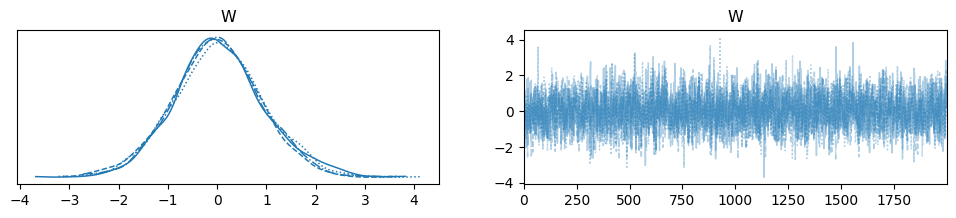

In [36]:
az.plot_trace(inference_data, var_names="W", coords={"W_dim_0":0, "W_dim_1":0})

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

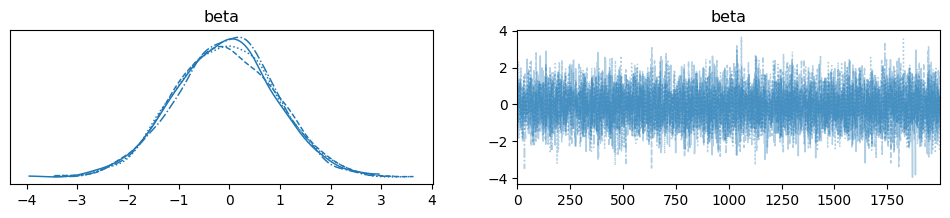

In [37]:
az.plot_trace(inference_data, var_names="beta", coords={"beta_dim_0":0, "beta_dim_1":0, "beta_dim_2":0})

array([[<Axes: title={'center': 'sigma_obpm'}>,
        <Axes: title={'center': 'sigma_obpm'}>]], dtype=object)

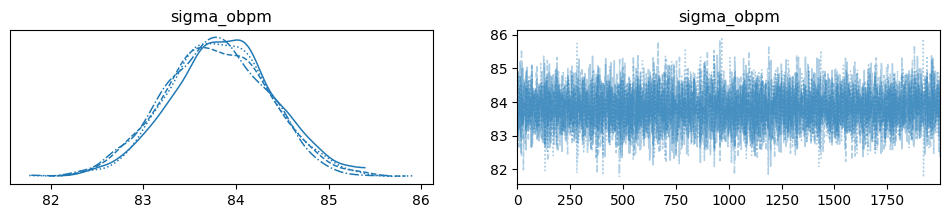

In [39]:
az.plot_trace(inference_data, var_names="sigma_obpm")

In [ ]:
inference_data

Inference data with groups:
	> posterior

In [40]:
W = results["W"]
with open("model_output/nba_rflvm.pkl", "rb") as f:
    results_rflvm = pickle.load(f)
f.close()

In [41]:
X = results_rflvm["X_raw"].mean(axis = 0)
U, _, _ = np.linalg.svd(X, full_matrices=False)
L       = np.linalg.cholesky(np.cov(U.T) + 1e-6 * np.eye(2)).T
aligned_X  = np.linalg.solve(L, U.T).T
X_tvrflvm_aligned = aligned_X / np.std(X, axis=0)
wTx = np.einsum("nr,ijmr -> ijnm", X_tvrflvm_aligned, W)
phi = np.concatenate([np.cos(wTx), np.sin(wTx)], -1) * (1/ np.sqrt(10))

In [42]:
results["phi"] = phi

In [43]:
results["phi"].shape

(4, 2000, 2328, 100)

In [44]:
results["beta"].squeeze().shape

(4, 2000, 100, 21)

In [45]:
mu = np.einsum("ijnk,ijmkt -> ijmnt", results["phi"], results["beta"])

In [46]:
results["mu"] = mu

In [47]:
from data.data_utils import create_fda_data

In [48]:
data["log_min"] = np.log(data["minutes"])
data["simple_exposure"] = 1 
_ , outputs, _ = create_fda_data(data, basis_dims=2, metric_output=(["gaussian"])*3, metrics=["log_min","obpm","dbpm"], exposure_list=["simple_exposure","minutes", "minutes"])

In [49]:
obpm_exposure = outputs[1]["exposure_data"]
dbpm_exposure = outputs[2]["exposure_data"]

In [50]:
inds = np.where(np.isnan(obpm_exposure))
obpm_exposure = obpm_exposure.at[inds].set(np.take(np.nanmean(obpm_exposure, axis = 0), inds[1]))

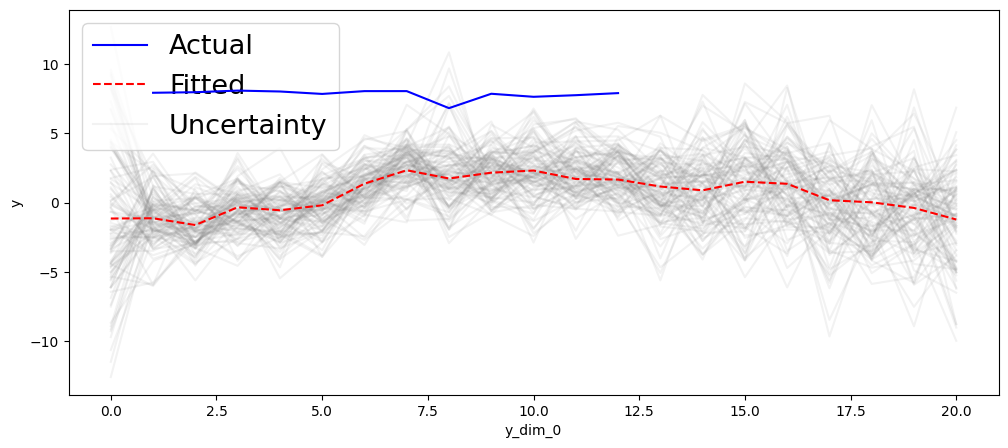

In [54]:
plot_metric_trajectory(0, 1189, results["mu"], np.stack([output["output_data"] for output in outputs], axis = 1), exposures = obpm_exposure, metric_output = "gaussian", posterior_variance_samples=results["sigma_obpm"])

In [53]:
np.where(names == "Kevin Durant")

(array([1189]),)